# 🧬 Training pipeline: Training retrieval model

In this notebook, you will train a retrieval model that will be able to quickly generate a small subset of candidate items from a large collection of items. Your model will be based on the *two-tower architecture*, which embeds queries and candidates (keys) into a shared low-dimensional vector space. Here, a query consists of features of a customer and a transaction (e.g. timestamp of the purchase), whereas a candidate consists of features of a particular item. All queries will have a user ID and all candidates will have an item ID, and the model will be trained such that the embedding of a user will be close to all the embeddings of items the user has previously bought.

After training the model you will save and upload its components to the Vertex AI Model Registry.

Let's go ahead and load the data.

## 📝 Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

from loguru import logger

from recsys import gcp_integrations, training
from recsys.config import settings

## ☁️ Connect to Vertex AI Feature Online Store

In [2]:
fos = gcp_integrations.get_feature_store()

2025-02-13 14:42:01.133 | INFO     | recsys.gcp_integrations.feature_store:get_feature_store:23 - Retrieving Feature Store from us-central1/recsys-dev-gonzo/recsys_feature_store_dev


## 💿 Create training dataset
You will train your retrieval model with a subset of features.

For the query embedding you will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding you will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.

In [3]:
trans_fv, articles_fv, customers_fv = gcp_integrations.feature_store.create_retrieval_feature_view(fos)

In [4]:
training_data = gcp_integrations.feature_store.create_training_dataset(trans_fv, articles_fv, customers_fv)

2025-02-13 14:42:04.988 | INFO     | recsys.features.ranking:fetch_feature_view_data:19 - Starting to fetch data from feature view: transactions
2025-02-13 14:42:05.461 | INFO     | recsys.features.ranking:fetch_feature_view_data:33 - Executing query: SELECT customer_id, article_id, t_dat, price, month_sin, month_cos FROM `recsys-dev-gonzo.recsys_dataset.recsys_transactions`


BadRequest: 400 Unrecognized name: month_sin at [1:47]; reason: invalidQuery, location: query, message: Unrecognized name: month_sin at [1:47]

Location: us-central1
Job ID: d6dd7182-1663-4214-9cd6-3b351f4b8c67


In [5]:
dataset = training.two_tower.TwoTowerDataset(
    training_data=training_data , batch_size=settings.TWO_TOWER_MODEL_BATCH_SIZE
)



In [6]:
train_ds, val_ds = dataset.get_train_val_split()

2025-02-13 12:59:49.309 | INFO     | recsys.training.two_tower:get_train_val_split:258 - Retrieving and creating train, eval, test split...


Let's take a look at our dataset:

In [ ]:
logger.info(f"Training samples: {len(dataset.properties['train_df']):,}")
logger.info(f"Validation samples: {len(dataset.properties['val_df']):,}")

logger.info(f"Number of users: {len(dataset.properties['user_ids']):,}")
logger.info(f"Number of items: {len(dataset.properties['item_ids']):,}")

2025-02-13 12:59:49.373 | INFO     | __main__:<module>:1 - Training samples: 19,005
2025-02-13 12:59:49.374 | INFO     | __main__:<module>:2 - Validation samples: 2,389
2025-02-13 12:59:49.374 | INFO     | __main__:<module>:4 - Number of users: 967
2025-02-13 12:59:49.374 | INFO     | __main__:<module>:5 - Number of items: 12,031


In [ ]:
dataset.properties["train_df"].head()

customer_id,article_id,t_dat,price,month_sin,month_cos,age,club_member_status,age_group,garment_group_name,index_group_name
str,str,i64,f64,f64,f64,f64,str,str,str,str
"""20409548ee6c82016a0c499389cee3…","""618800007""",1566777600,0.033881,-0.866025,-0.5,26.0,"""PRE-CREATE""","""26-35""","""Blouses""","""Ladieswear"""
"""f078fde7e59a1450c95aeca532f8db…","""893351002""",1592352000,0.015237,1.2246e-16,-1.0,45.0,"""ACTIVE""","""36-45""","""Dresses Ladies""","""Divided"""
"""e4ff7e2563aa65a05ef1b753ccf0a1…","""464277017""",1577836800,0.022017,0.5,0.866025,51.0,"""ACTIVE""","""46-55""","""Under-, Nightwear""","""Ladieswear"""
"""7230bd0e13cdb38ce9d09bc7126d71…","""801512004""",1562630400,0.042356,-0.5,-0.866025,28.0,"""PRE-CREATE""","""26-35""","""Jersey Fancy""","""Sport"""
"""67b2fb6ebf802abcc7310bf98847fb…","""850917001""",1600560000,0.025407,-1.0,-1.8370e-16,19.0,"""ACTIVE""","""19-25""","""Blouses""","""Ladieswear"""


## 🗼🗼 Build the Two Tower model

The two tower model consist of two models:
- **Query model**: Generates a query representation of a given user and transaction features.
- **Candidate model**: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space**. You let this space be low-dimensional to prevent overfitting on the training data. (Otherwise, the model might simply memorize previous purchases, which makes it recommend items customers already have bought).

You start with creating the query model.

In [9]:
query_model_factory = training.two_tower.QueryTowerFactory(dataset=dataset)
query_model = query_model_factory.build()

The candidate model is very similar to the query model. A difference is that it has two categorical features as input, which you one-hot encode.

In [10]:
item_model_factory = training.two_tower.ItemTowerFactory(dataset=dataset)
item_model = item_model_factory.build()

You will evaluate the two tower model using the *top-100 accuracy*. That is, for each transaction in the validation data you will generate the associated query embedding and retrieve the set of the 100 items that are closest to this query in the embedding space. The top-100 accuracy measures how often the item that was actually bought is part of this subset. To evaluate this, you create a dataset of all unique items in the training data.

Create a TwoTowerModel with the specified **query_model** and **item_model**:

In [11]:
model_factory = training.two_tower.TwoTowerFactory(dataset=dataset)
model = model_factory.build(query_model=query_model, item_model=item_model)

### Training the model

In [ ]:
trainer = training.two_tower.TwoTowerTrainer(dataset=dataset, model=model)
history = trainer.train(train_ds, val_ds)

Epoch 1/10
10/10 [==============================] - 1s 27ms/step - loss: 14467.5738 - regularization_loss: 0.0000e+00 - total_loss: 14467.5738 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 1954.1682 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1954.1682
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 13951.4557 - regularization_loss: 0.0000e+00 - total_loss: 13951.4557 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+0

Let's take a look at the training and validation loss:

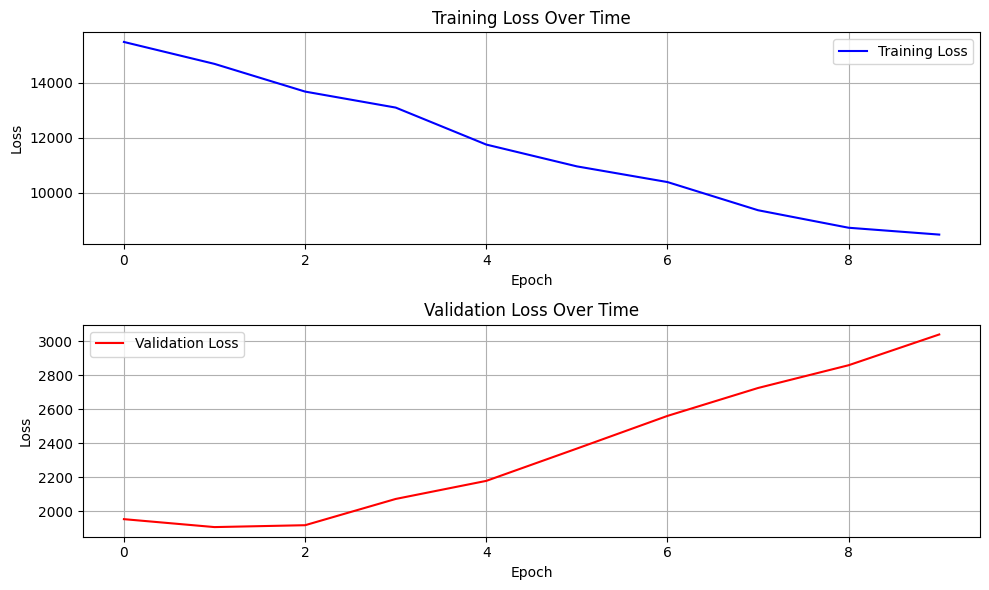

In [14]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Training loss subplot
ax1.plot(history.history["loss"], label="Training Loss", color="blue")
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Validation loss subplot
ax2.plot(history.history["val_loss"], label="Validation Loss", color="red")
ax2.set_title("Validation Loss Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()  # Uncomment to show the plot

# 🗄️ Upload models to Vertex AI model registry

In [23]:
serving_container = f"{settings.GCP_LOCATION}-docker.pkg.dev/{settings.GCP_PROJECT}/{settings.GCP_ARTIFACT_REGISTRY}/two-tower:latest"

query_model_registry  = gcp_integrations.model_registry.upload_model_to_registry(
    model=query_model,
    model_name="two_tower_query",
    model_display_name="Two Tower Query Model",
    description="Query tower model for candidate generation",
    serving_container_image_uri= serving_container,
)

item_model_registry = gcp_integrations.model_registry.upload_model_to_registry(
    model=item_model,
    model_name="two_tower_item",
    model_display_name="Two Tower Item Model",
    description="Item twoer mode for candidate generation",
    serving_container_image_uri=serving_container,
)

2025-02-13 14:41:12.487 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:22 - Saving model into: /tmp/two_tower_query


INFO:tensorflow:Assets written to: /tmp/two_tower_query/assets


INFO:tensorflow:Assets written to: /tmp/two_tower_query/assets
2025-02-13 14:41:13.810 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:25 - Uploading model to Two Tower Query Model to Vertex AI


NotFound: 404 The Artifact Registry repository projects/recsys-dev-gonzo/locations/us-central1/repositories/gonzo-recsys-artifacts does not exist.

Save models

In [ ]:
# TO - DO
# ALSO CREATE THE METHODS TO UPLOAD THE MODEL TO THE REGISTRY

None